# Import necessary libraries

In [37]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
import itertools

In [38]:
#Constants
IMG_SIZE = 48
DATA_DIR = '/kaggle/input/facial-emotion-recognition/images'
EMOTIONS = ['Anger', 'Contempt', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprised']

# Load the dataset
csv_path = '/kaggle/input/facial-emotion-recognition/emotions.csv'
df = pd.read_csv(csv_path)
df.head(10)

,set_id,gender,age,country
0,0,FEMALE,36,RU
1,1,FEMALE,37,RU
2,2,FEMALE,36,RU
3,3,MALE,29,RU
4,4,FEMALE,43,RU
5,5,MALE,49,RU
6,6,FEMALE,38,RU
7,7,MALE,19,PH
8,8,FEMALE,29,RU
9,9,FEMALE,32,RU


In [39]:
df['set_id'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])

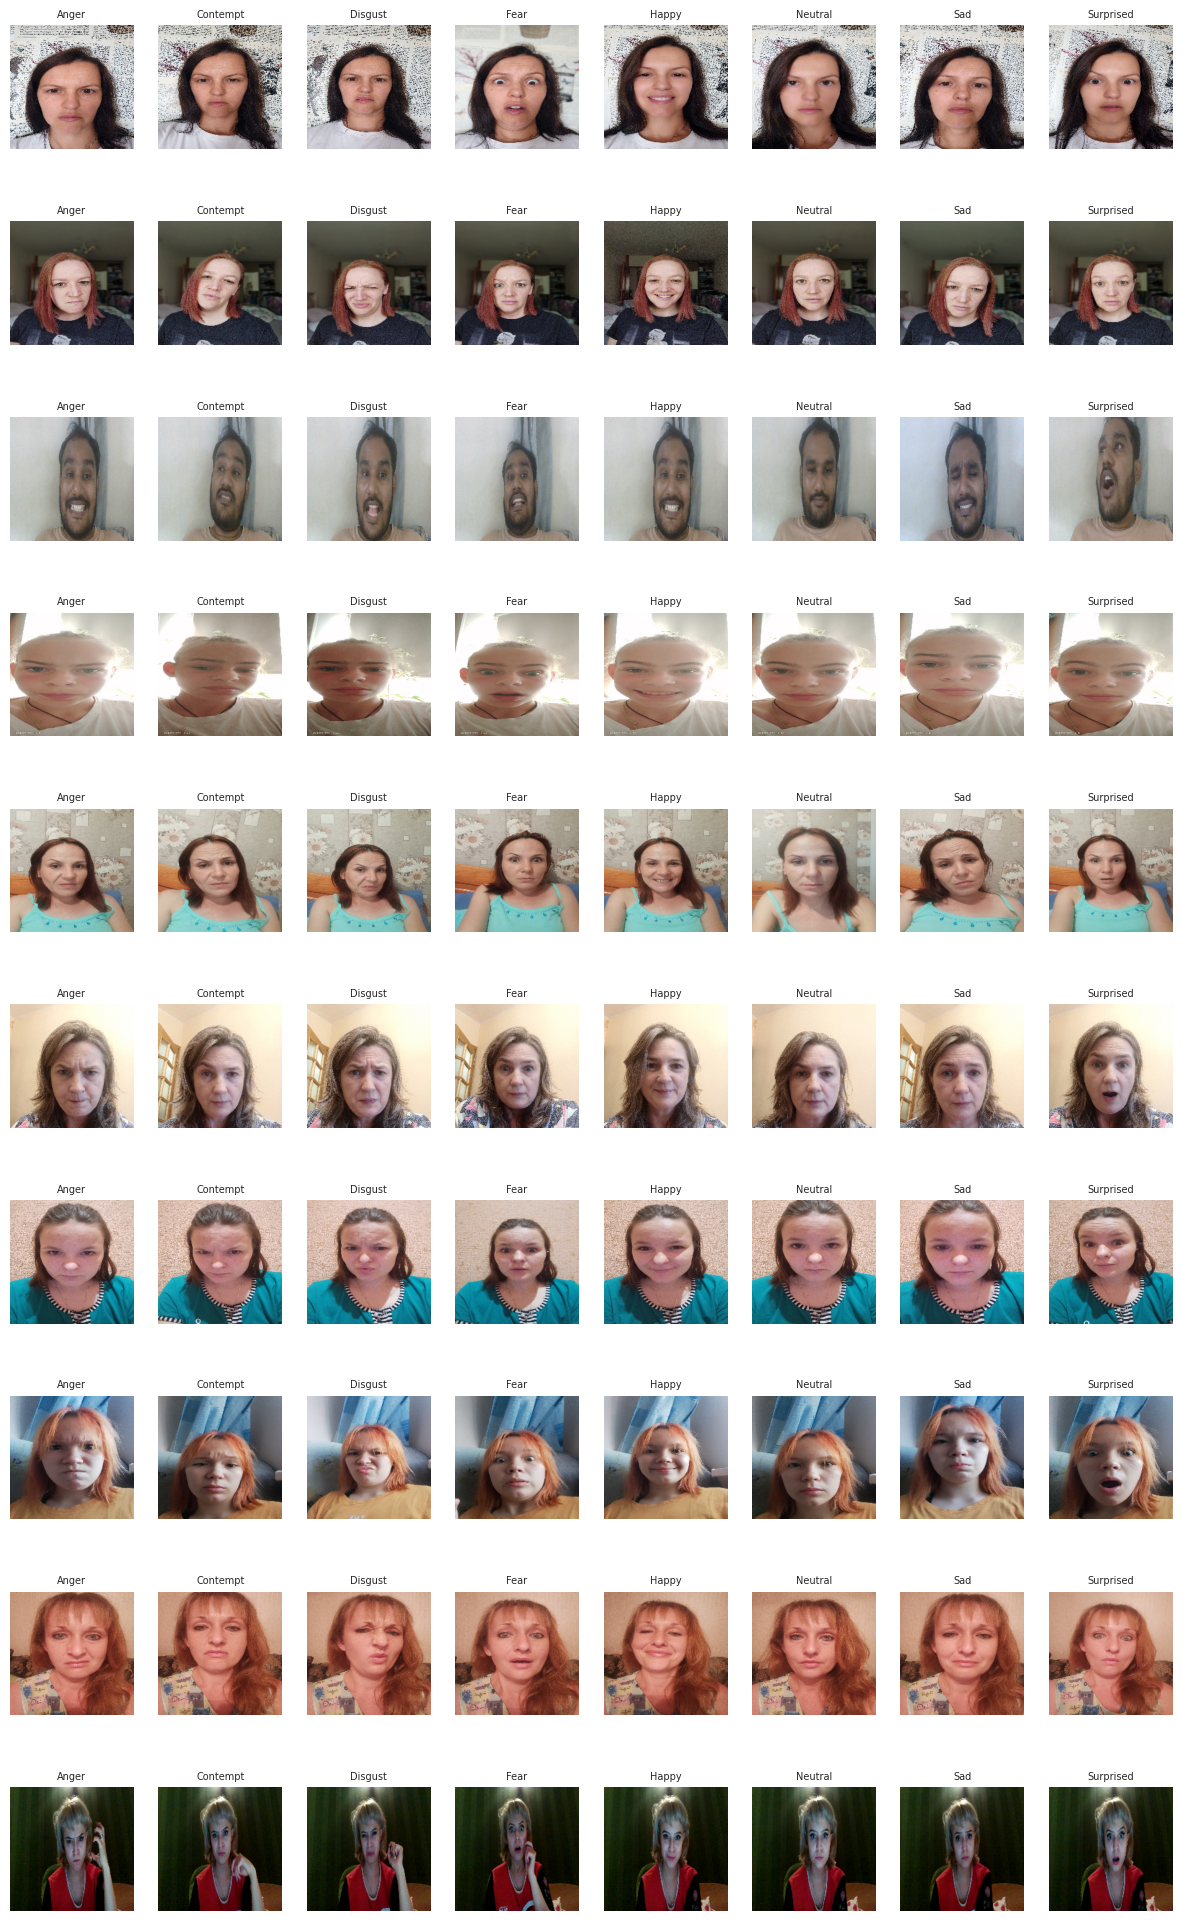

In [40]:
DIR = '/kaggle/input/facial-emotion-recognition'
path_imgs = os.path.join(DIR, 'images')
# Get all folder names
all_folders = sorted([f for f in os.listdir(path_imgs) if os.path.isdir(os.path.join(path_imgs, f))])
folders_to_process = all_folders[:10]
plt.figure(figsize=(15, 25))
IM_SIZE = (200, 200)
ind = 0

for folder_name in folders_to_process: 
    set_id = int(folder_name) 
    
    for class_name in EMOTIONS:
        ind += 1
        path_img = os.path.join(path_imgs, str(set_id), class_name.capitalize() + '.jpg')  
        
        if not os.path.isfile(path_img):
            print(f"Warning: File {path_img} does not exist.")
            continue
        
        img = cv2.imread(path_img)
        
        if img is None:
            print(f"Warning: Could not load image at {path_img}. Skipping.")
            continue
        
        img = cv2.resize(img, IM_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(len(folders_to_process), len(EMOTIONS), ind)
        plt.title(class_name, fontsize=7)
        plt.imshow(img)
        plt.axis('off')

plt.show()

# EDA

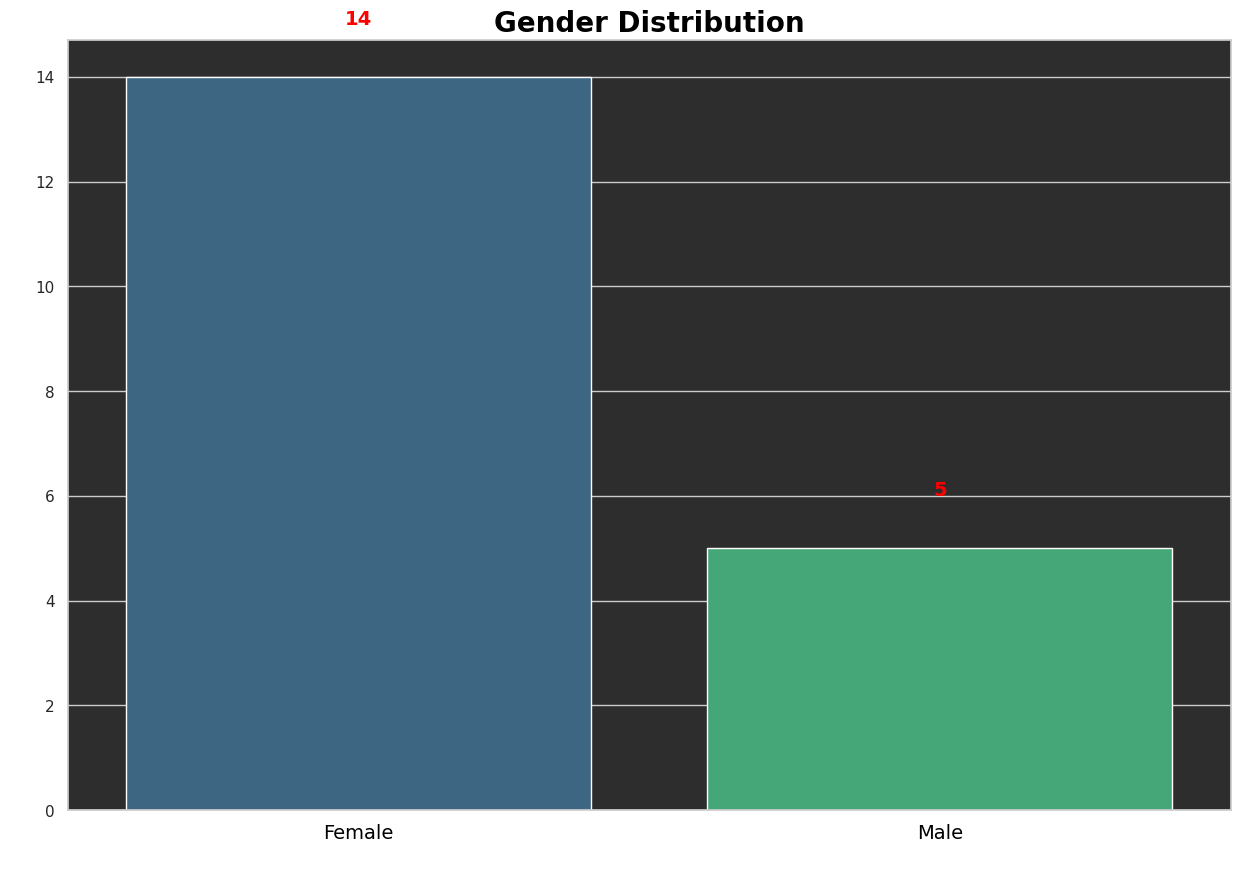

In [41]:
# Set style to darkgrid
sns.set(style="whitegrid")

# Gender distribution
plt.figure(figsize=(15, 10))
gender_counts = df['gender'].value_counts()

# Create the bar plot with a different color palette
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette="viridis", edgecolor="white")

# Add title and labels with adjusted font sizes
plt.title('Gender Distribution', fontsize=20, weight='bold', color='black')
plt.xlabel('Gender', fontsize=16, color='white')
plt.ylabel('Count', fontsize=16, color='white')

# Customize x-ticks
plt.xticks(ticks=[0, 1], labels=['Female', 'Male'], fontsize=14, color='black')

# Add data labels to each bar
for index, value in enumerate(gender_counts.values):
    plt.text(index, value + 1, str(value), ha='center', fontsize=14, weight='bold', color='red')

# Adjust background color to match the darkgrid style
plt.gca().patch.set_facecolor('#2d2d2d')

# Display the plot
plt.show()

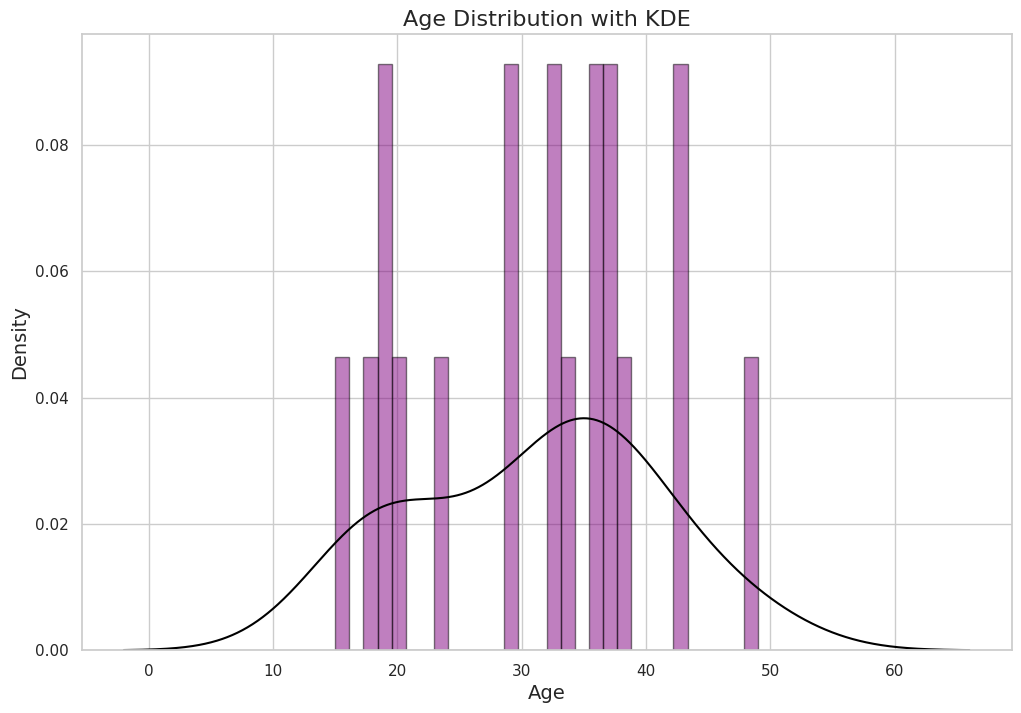

In [42]:
# Age distribution with KDE
plt.figure(figsize=(12, 8))
df['age'].plot(kind='hist', bins=30, density=True, alpha=0.5, color='purple', edgecolor='black')
df['age'].plot(kind='kde', color='black')
plt.title('Age Distribution with KDE', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.show()

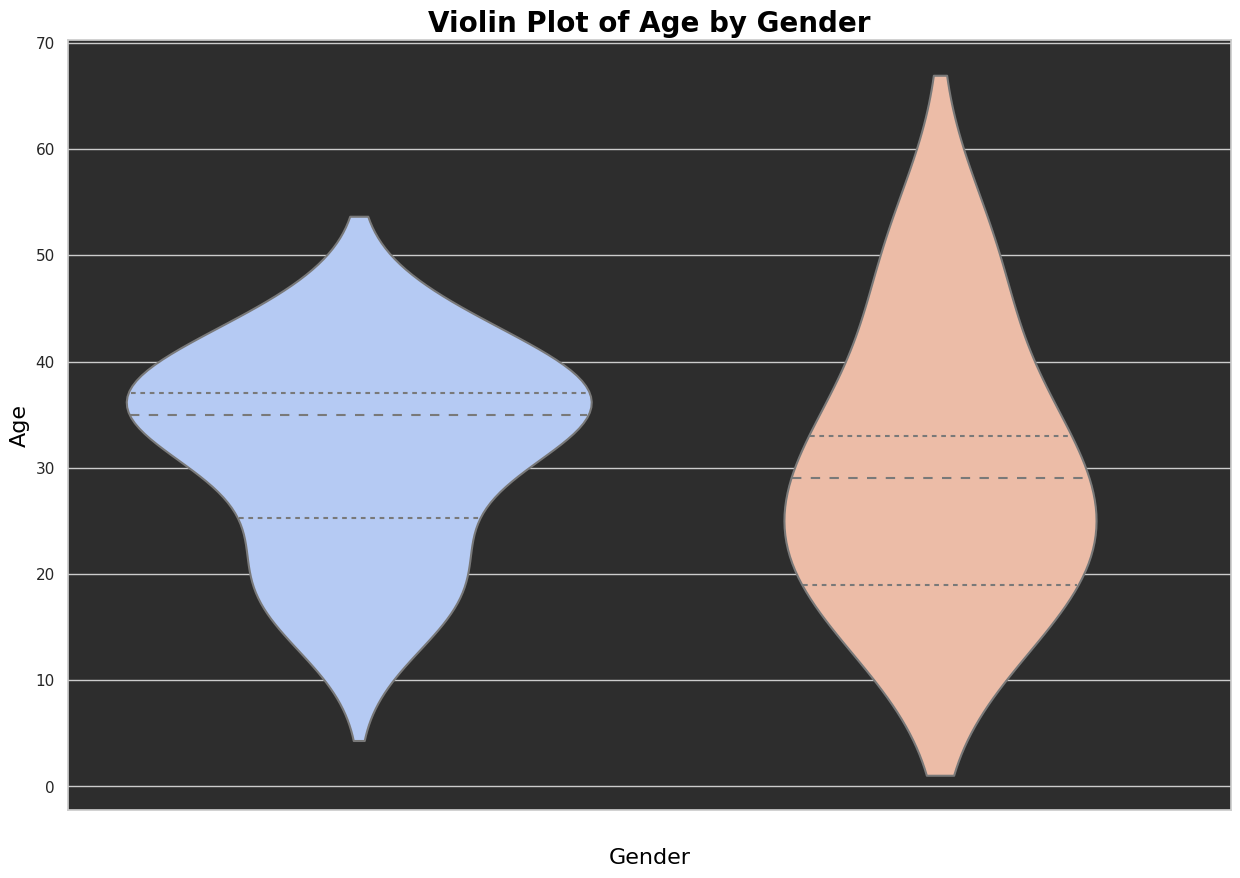

In [43]:
plt.figure(figsize=(15, 10))
sns.violinplot(x='gender', y='age', data=df, palette="coolwarm", inner="quartile")
plt.title('Violin Plot of Age by Gender', fontsize=20, weight='bold', color='black')
plt.xlabel('Gender', fontsize=16, color='black')
plt.ylabel('Age', fontsize=16, color='black')
plt.xticks([0, 1], ['Female', 'Male'], fontsize=14, color='white')
plt.gca().patch.set_facecolor('#2d2d2d')
plt.show()

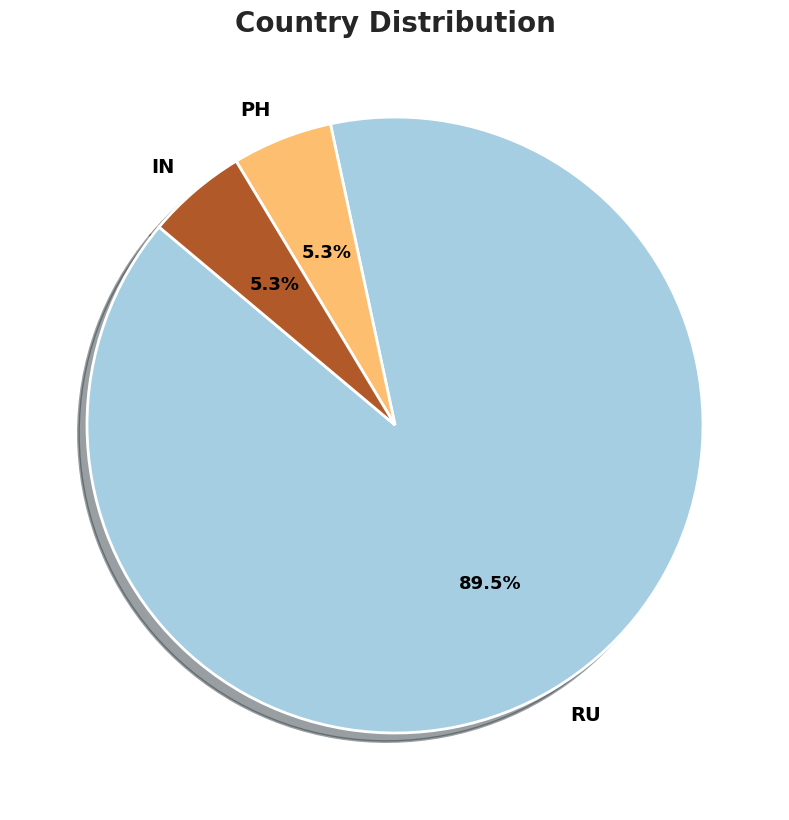

In [44]:
# Set the style
sns.set(style="whitegrid")

country_counts = df['country'].value_counts()

plt.figure(figsize=(15, 10))

colors = plt.cm.Paired(np.linspace(0, 1, len(country_counts)))

# Plot the pie chart
wedges, texts, autotexts = plt.pie(
    country_counts, 
    labels=country_counts.index, 
    autopct='%1.1f%%', 
    colors=colors, 
    startangle=140, 
    wedgeprops=dict(edgecolor='white', linewidth=2),
    shadow=True,
    textprops=dict(color="black", fontsize=12)
)

# Style the text labels and percentage texts
for text in texts:
    text.set_fontsize(14)
    text.set_fontweight('bold')

for autotext in autotexts:
    autotext.set_fontsize(13)
    autotext.set_fontweight('bold')
    autotext.set_color('black')

plt.title('Country Distribution', fontsize=20, weight='bold')

plt.show()

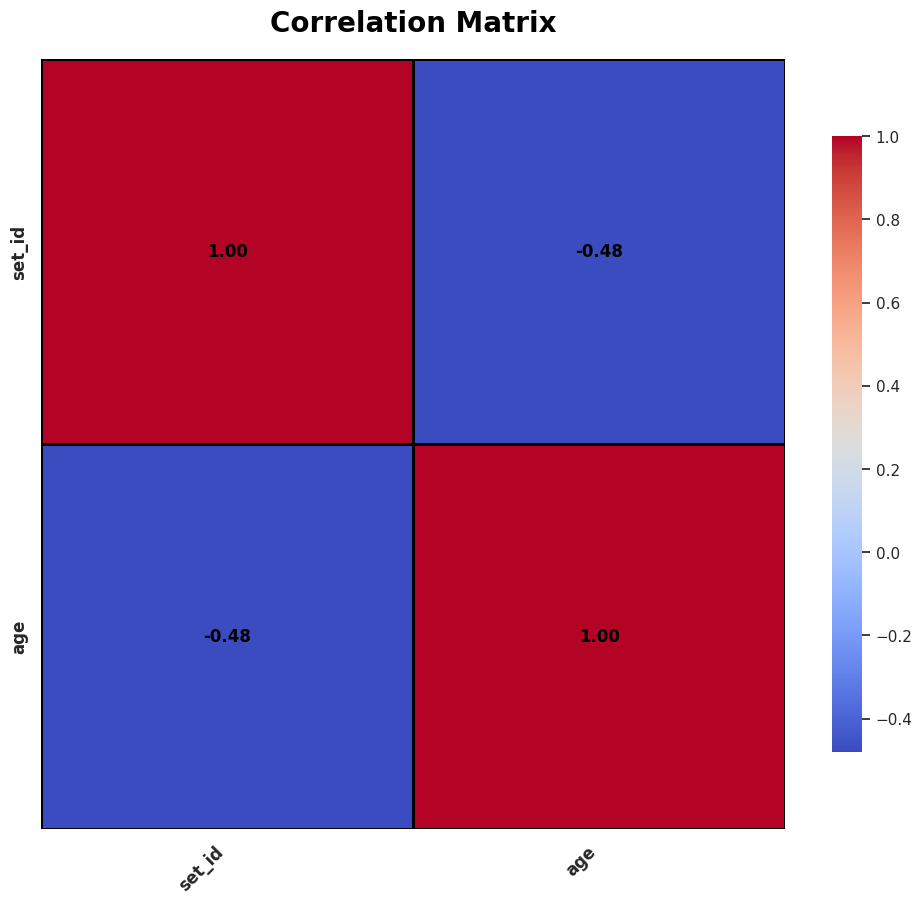

In [45]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 10))

numeric_cols = df.select_dtypes(include=[np.number])

corr = numeric_cols.corr()

sns.heatmap(
    corr, 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    linewidths=1, 
    linecolor='black', 
    cbar_kws={"shrink": 0.8},
    annot_kws={"size": 12, "weight": "bold", "color": "black"}
)

plt.title('Correlation Matrix', fontsize=20, weight='bold', color='black', pad=20)

plt.xticks(fontsize=12, rotation=45, ha="right", weight='bold')
plt.yticks(fontsize=12, weight='bold')

plt.show()

# Data Preparation

In [46]:
# Encode the gender column
label_encoder = LabelEncoder()
df['gender'] = label_encoder.fit_transform(df['gender'])

In [47]:
# Function to load and preprocess images
def load_data():
    images = []
    labels = []
    
    for emotion_label, emotion in enumerate(EMOTIONS):
        # Get the directory for the current emotion
        emotion_dir = os.path.join(DATA_DIR, str(emotion_label))
        if os.path.isdir(emotion_dir):
            for img_file in os.listdir(emotion_dir):
                img_path = os.path.join(emotion_dir, img_file)
                img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                images.append(img_resized)
                labels.append(emotion_label)  # Assigning label based on index
        else:
            print(f"Directory not found for emotion {emotion}: {emotion_dir}")
        
    return np.array(images), np.array(labels)

images, labels = load_data()

In [48]:
# Normalize images
images = images / 255.0

# Encode labels to categorical
labels_categorical = to_categorical(labels, num_classes=len(EMOTIONS))

In [49]:
# Check the distribution of the labels to ensure balance
print("Distribution of emotions:")
print(pd.Series(labels).value_counts())

Distribution of emotions:
0    8
1    8
2    8
3    8
4    8
5    8
6    8
7    8
Name: count, dtype: int64


In [50]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

In [51]:
# Reshape for the model
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

# Build and Train the model

In [52]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(EMOTIONS), activation='softmax') 
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test))



Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 327ms/step - accuracy: 0.0966 - loss: 2.0932 - val_accuracy: 0.4615 - val_loss: 2.1036
Epoch 2/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.0966 - loss: 2.0728 - val_accuracy: 0.2308 - val_loss: 2.0963
Epoch 3/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.2402 - loss: 2.0563 - val_accuracy: 0.5385 - val_loss: 2.0816
Epoch 4/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.2429 - loss: 2.0176 - val_accuracy: 0.3077 - val_loss: 2.0642
Epoch 5/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.2637 - loss: 1.9657 - val_accuracy: 0.3077 - val_loss: 2.0326
Epoch 6/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3368 - loss: 1.9142 - val_accuracy: 0.4615 - val_loss: 1.9504
Epoch 7/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4230 - loss: 1.8764 - val_accuracy: 0.4615 - val_loss: 1.8230
Epoch 8/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4046 - loss: 1.7884 - val_accuracy: 0.5385 - val_loss: 1.7009
Epoch 9/40

In [53]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


# Visualise Metrics 

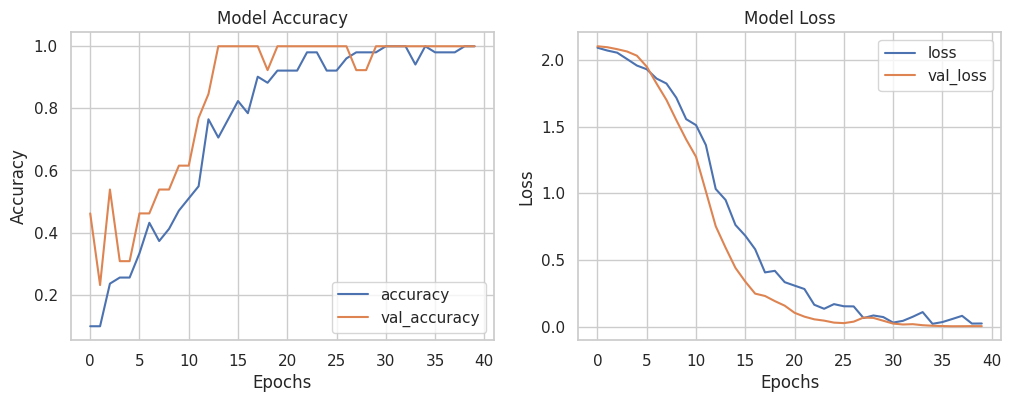

In [54]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


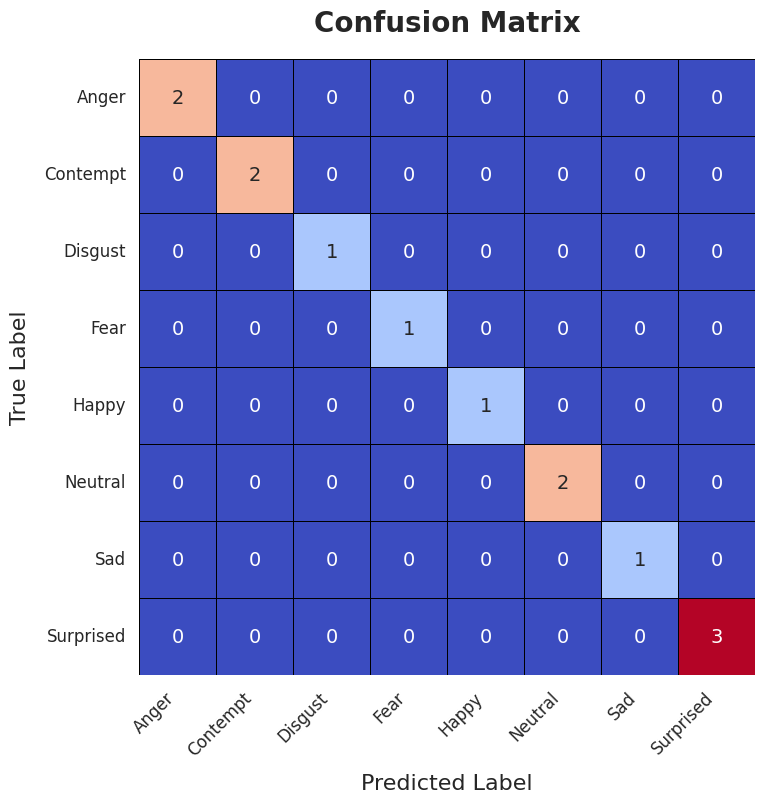

              precision    recall  f1-score   support

       Anger       1.00      1.00      1.00         2
    Contempt       1.00      1.00      1.00         2
     Disgust       1.00      1.00      1.00         1
        Fear       1.00      1.00      1.00         1
       Happy       1.00      1.00      1.00         1
     Neutral       1.00      1.00      1.00         2
         Sad       1.00      1.00      1.00         1
   Surprised       1.00      1.00      1.00         3

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13



In [55]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
cm_df = pd.DataFrame(cm, index=EMOTIONS, columns=EMOTIONS)

plt.figure(figsize=(12, 8))
sns.set(font_scale=1.2)  
sns.heatmap(cm_df, annot=True, fmt='d', cmap='coolwarm', linewidths=0.5, linecolor='black', cbar=False, 
            annot_kws={"size": 14}, square=True)

plt.title('Confusion Matrix', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=16, labelpad=10)
plt.ylabel('True Label', fontsize=16, labelpad=10)
plt.xticks(rotation=45, ha='right', fontsize=12)  
plt.yticks(rotation=0, fontsize=12)

plt.show()

# Classification Report
report = classification_report(y_true, y_pred_classes, target_names=EMOTIONS)
print(report)


# Show Prediction

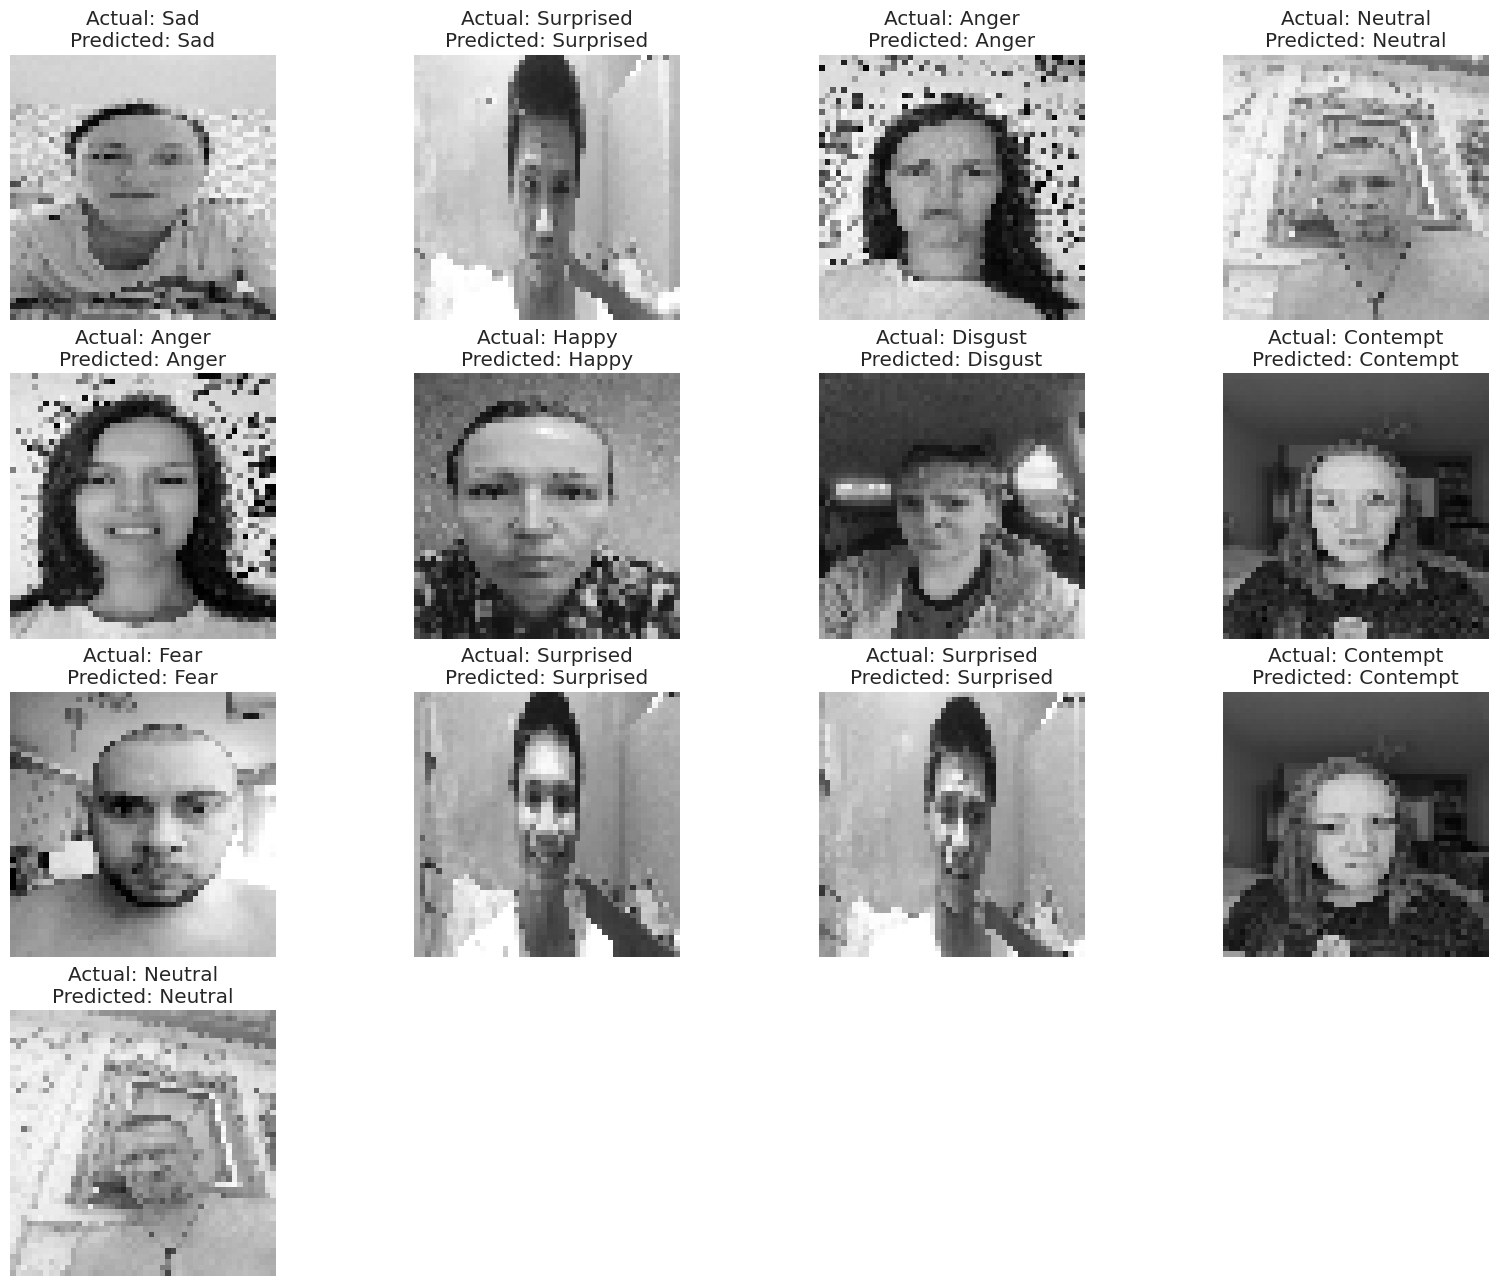

In [56]:
num_images = min(20, len(X_test))
plt.figure(figsize=(20, 20))
for i in range(num_images):
    plt.subplot(5, 4, i + 1)
    
    img = X_test[i].copy()
    img = img * 255  
    img = img.astype(np.uint8)  
    
    if img.shape[-1] == 1:  
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    else:  
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.imshow(img)
    plt.title(f"Actual: {EMOTIONS[y_true[i]]}\nPredicted: {EMOTIONS[y_pred_classes[i]]}")
    plt.axis('off')
plt.show()
